In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from math import ceil, floor
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Plots import lens_plot
from lensing_data_class import LensingData
from cluster_local_tidy import ClusterLensing
from astropy.cosmology import FlatLambdaCDM
import pandas as pd
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

In [2]:
# inject data

scenarios = {
    '1': 'abell370',
    '2': 'abell2744',
    '3': 'abells1063',
    '4': 'macs0416',
    '5': 'macs0717',
    '6': 'macs1149'
}

full_cluster_names = {
    'abell370': 'Abell 370',
    'abell2744': 'Abell 2744',
    'abells1063': 'Abell S1063',
    'macs0416': 'MACS J0416.1-2403',
    'macs0717': 'MACS J0717.5+3745',
    'macs1149': 'MACS J1149.5+2223'
}

# Initialize lists to store the data arrays
datax_list = []
datay_list = []
data_psi_list = []
data_sigma_dt_list = []

for i in scenarios:
    clustername = scenarios[i]
    full_cluster_name = full_cluster_names[clustername]

    file_dir = os.getcwd()
    fits_filex = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/cats copy/hlsp_frontier_model_{clustername}_cats_v4_x-arcsec-deflect.fits'
    )
    fits_filey = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/cats copy/hlsp_frontier_model_{clustername}_cats_v4_y-arcsec-deflect.fits'
    )
    psi_file = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/cats copy/hlsp_frontier_model_{clustername}_cats_v4_psi.fits'
    )
    sigma_dt_file = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/cats copy/hlsp_frontier_model_{clustername}_cats_v4_sigma_dt.fits'
    )

    with fits.open(fits_filex) as hdulx, fits.open(fits_filey) as hduly, fits.open(psi_file) as hdul_psi, fits.open(sigma_dt_file) as hdul_sigma_dt:
        datax = hdulx[0].data
        datay = hduly[0].data
        data_psi = hdul_psi[0].data
        data_sigma_dt = hdul_sigma_dt[0].data

        # Append the data arrays to the lists
        datax_list.append(datax)
        datay_list.append(datay)
        data_psi_list.append(data_psi)
        data_sigma_dt_list.append(data_sigma_dt)

pixscale_list = [0.2, 0.3, 0.2, 0.3, 0.8, 0.5]
z_l_list = [0.375, 0.308, 0.351, 0.397, 0.545, 0.543]
lensing_data = LensingData(
    alpha_maps_x=datax_list,
    alpha_maps_y=datay_list,
    lens_potential_maps=data_psi_list,
    pixscale = pixscale_list,
    uncertainty_dt=data_sigma_dt_list,
    z_l_list = z_l_list,
)
# Example: Access the first datax array
lengths = [len(arr) for arr in datax_list]
print(f"Lengths of the datax arrays: {lengths}")

Lengths of the datax arrays: [800, 1200, 1000, 800, 600, 600]


In [3]:
# getting the pixel scale list
def get_pixscale(cluster_name, file_path='GCdata/pixsize'):
    full_path = os.path.join(file_dir, file_path)
    with open(full_path, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith(cluster_name):
                # Split the line to get the value after the colon and return it as a float
                return float(line.split(':')[1].strip())
    return None  # Return None if the cluster name isn't found

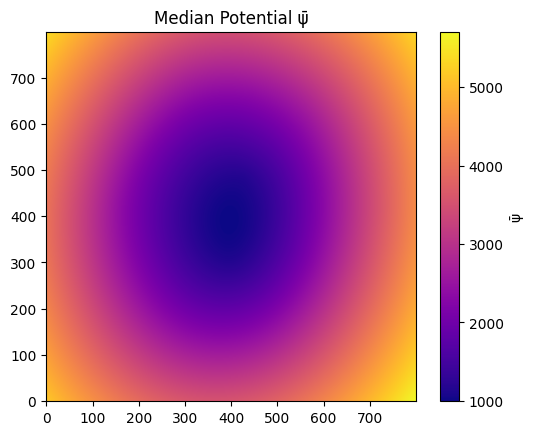

In [4]:
data_psi_cut = data_psi_list[0]
plt.imshow(data_psi_cut, origin='lower', cmap='plasma')
plt.title("Median Potential ψ̄")
plt.colorbar(label="ψ̄")

scal: 0.7789443275541896
800


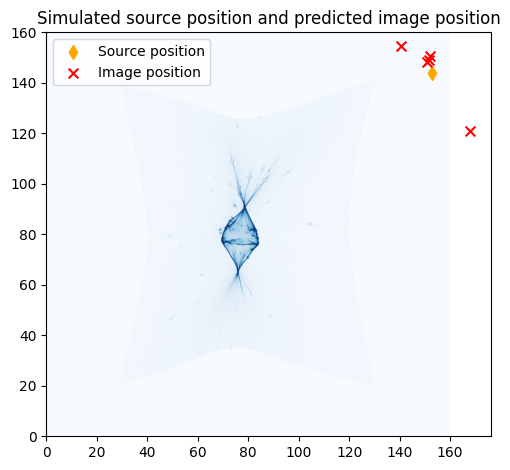

In [4]:
# look at the lens map
index = 0
cosmology = FlatLambdaCDM(H0=70, Om0=0.3)
z_l = z_l_list[index]
z_s = 3.293726569972465
D_LS = cosmology.angular_diameter_distance_z1z2(z_l, z_s)
D_S = cosmology.angular_diameter_distance(z_s)

# Scale deflection map
scal = D_LS / D_S
print(f"scal: {scal}")
size = len(datax_list[index])
print(size)
array_test = np.zeros((size,size))
pixscale = pixscale_list[index]
datay = datay_list[index]/pixscale
datax = datax_list[index]/pixscale
# scal factor for real deflection map
datay *= scal
datax *= scal
for i in range(0,size):
    for j in range(0,size):
        ycoord = i-datay[i,j]
        xcoord = j-datax[i,j]
        ydec = ycoord%1
        xdec = xcoord%1
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        array_test[yfloor,xfloor] += 1

plt.imshow(array_test, cmap='Blues', vmax = 50, origin='lower', extent=[0,size*pixscale,0,size*pixscale])
plt.scatter(152.64378604912187, 143.7258759600826, c = 'orange', marker='d', s=50)
plt.scatter([167.92671313, 140.37395319, 151.9208633 , 150.76187165,
       151.68633395], [121.00083589, 154.44239344, 150.43472388, 148.3354136 ,
       149.16337923], c = 'r', marker='x', s=50)
# plt.xlim(200,400)
# plt.ylim(200,400)

plt.title('Simulated source position and predicted image position')
plt.legend(['Source position','Image position'])
plt.tight_layout()
#plt.savefig('Report images sem2/new/src and img.pdf')

/home/dices/.venv/lib/python3.12/site-packages/lenstronomy/LensModel/lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(
/home/dices/.venv/lib/python3.12/site-packages/lenstronomy/LensModel/lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(
/home/dices/.venv/lib/python3.12/site-packages/lenstronomy/LensModel/lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(
/home/dices/.venv/lib/python3.12/site-packages/lenstronomy/LensModel/lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(
/home/dices/.venv/lib/python3.12/site-packages/lenstronomy/LensModel/lens_model.py:96: U

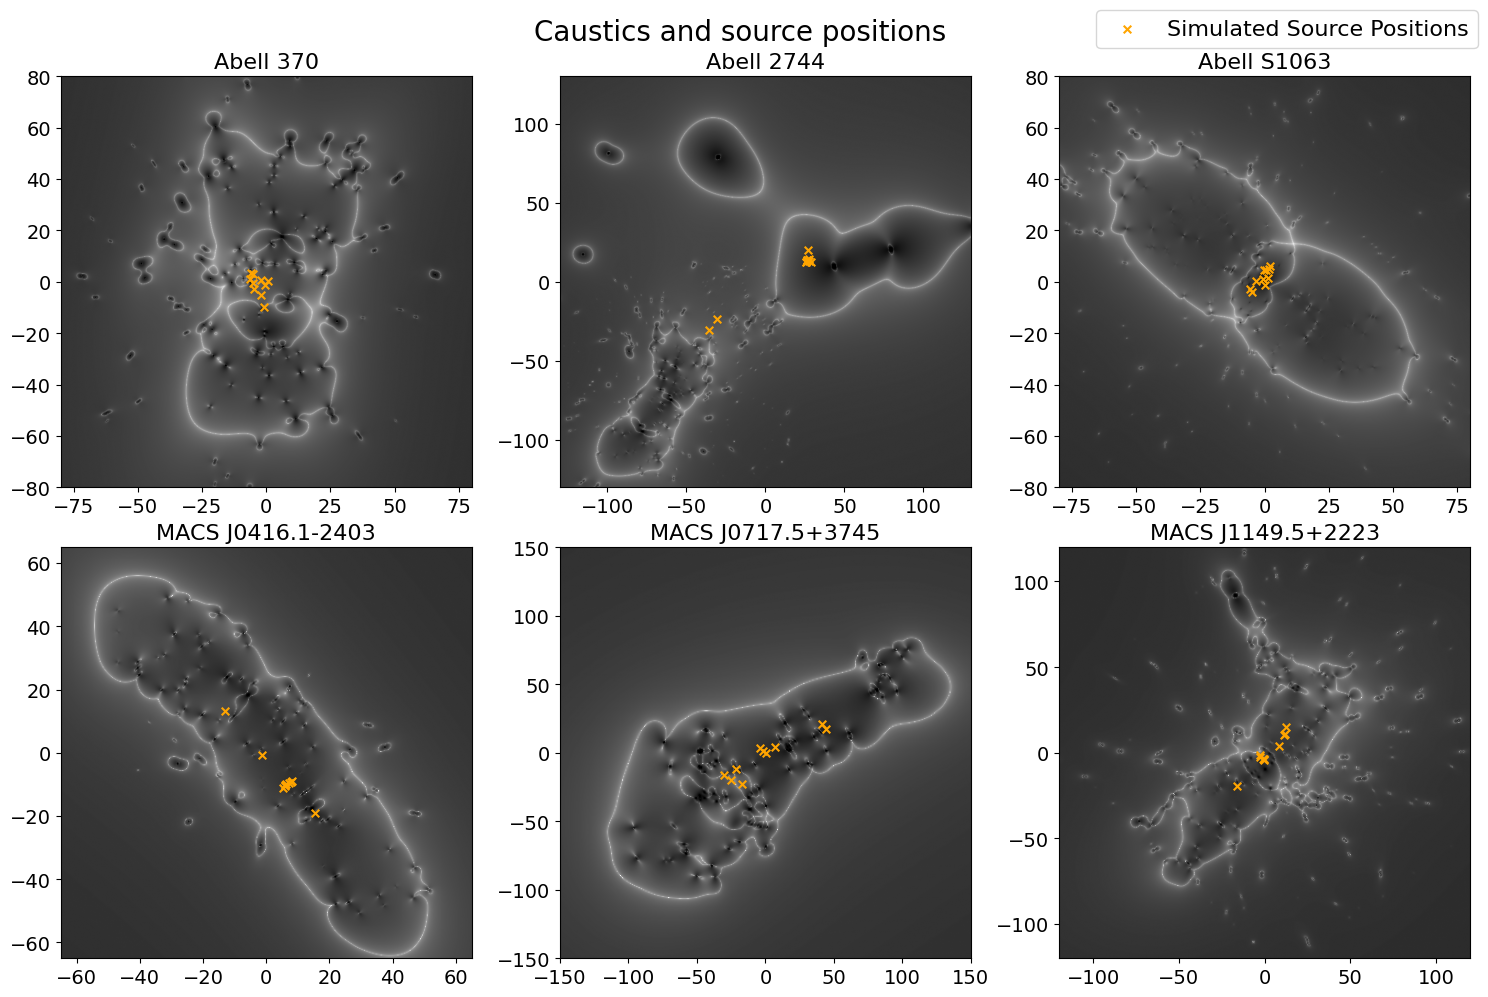

In [5]:
# make 6 graphs of the critical curves
from matplotlib.colors import LogNorm


fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Caustics and source positions', fontsize=20)
# Plot the caustics and source positions for each cluster in magnification maps
for index in range(6):
    lm = LensModel(lens_model_list=["INTERPOL"],
                               z_lens=z_l_list[index], cosmo=cosmology)
    size = len(datax_list[index])
    pixscale = pixscale_list[index]
    x_grid = np.linspace(-size/2*pixscale, size/2*pixscale, size)
    xx, yy = np.meshgrid(x_grid, x_grid)
    kwargs = [{
                "grid_interp_x": x_grid,
                "grid_interp_y": x_grid,
                "f_": data_psi_list[index],
                "f_x": datax_list[index],
                "f_y": datay_list[index],
            }]

    magnification_map = lm.magnification(xx, yy, kwargs=kwargs)
    ax = axs[index//3, index%3]
    im = ax.imshow(
        np.abs(magnification_map),
        origin='lower',
        cmap='gray',
        norm=LogNorm(vmin=1e-1, vmax=1e5),
        extent=[x_grid[0], x_grid[-1], x_grid[0], x_grid[-1]],
        
    )
    ax.tick_params(labelsize=14)
    ax.set_title(f'{full_cluster_names[scenarios[str(index+1)]]}', fontsize=16)
    # ax.set_xlabel('x', fontsize=16)
    # ax.set_ylabel('y', fontsize=16)
    # Load the source positions from the CSV file
    src_pos_df = pd.read_csv('/home/dices/Research/GWlensing_Brian/src_pos_tidy_xyz.csv')

    # Extract the (x, y) and (localized_x, localized_y) for the current cluster
    cluster_indices = src_pos_df[src_pos_df['indices'] == index]
    x = cluster_indices['x'].values
    y = cluster_indices['y'].values

    # transform the source position to -arcsecond to arcsecond
    x = x - size/2*pixscale
    y = y - size/2*pixscale

    # Plot the extracted positions on the current cluster's caustic plot
    ax.scatter(x, y, c='orange', marker='x', label='Simulated Source Positions', s=30)
    #fig.colorbar(im, ax=ax, shrink=0.75)
axs[0,1].set_xlim(-130, 130)
axs[0,1].set_ylim(-130, 130)
axs[0,2].set_xlim(-80, 80)
axs[0,2].set_ylim(-80, 80)
axs[1,0].set_xlim(-65, 65)
axs[1,0].set_ylim(-65, 65)
axs[1,1].set_xlim(-150, 150)
axs[1,1].set_ylim(-150, 150)
axs[1,2].set_xlim(-120, 120)
axs[1,2].set_ylim(-120, 120)
# Add a general legend for all the graphs
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right',fontsize="16")
plt.tight_layout()
#fig.colorbar(im, ax=axs.ravel().tolist(), label='|Magnification|', shrink=0.6)
#plt.figtext(0.5, -0.06, 'Figure 2: Plots for stimulated and optimized source positions after localization for each cluster. All the orange and magenta labels of the source positions\nare overlapping each other except one, which indicates that the optimized result is very close to true source positions most of the time.', ha='center', fontsize=14)
plt.show()

fig.savefig('Report images sem2/new/caustic and simulated src.pdf', bbox_inches='tight')

/home/dices/.venv/lib/python3.12/site-packages/lenstronomy/LensModel/lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(


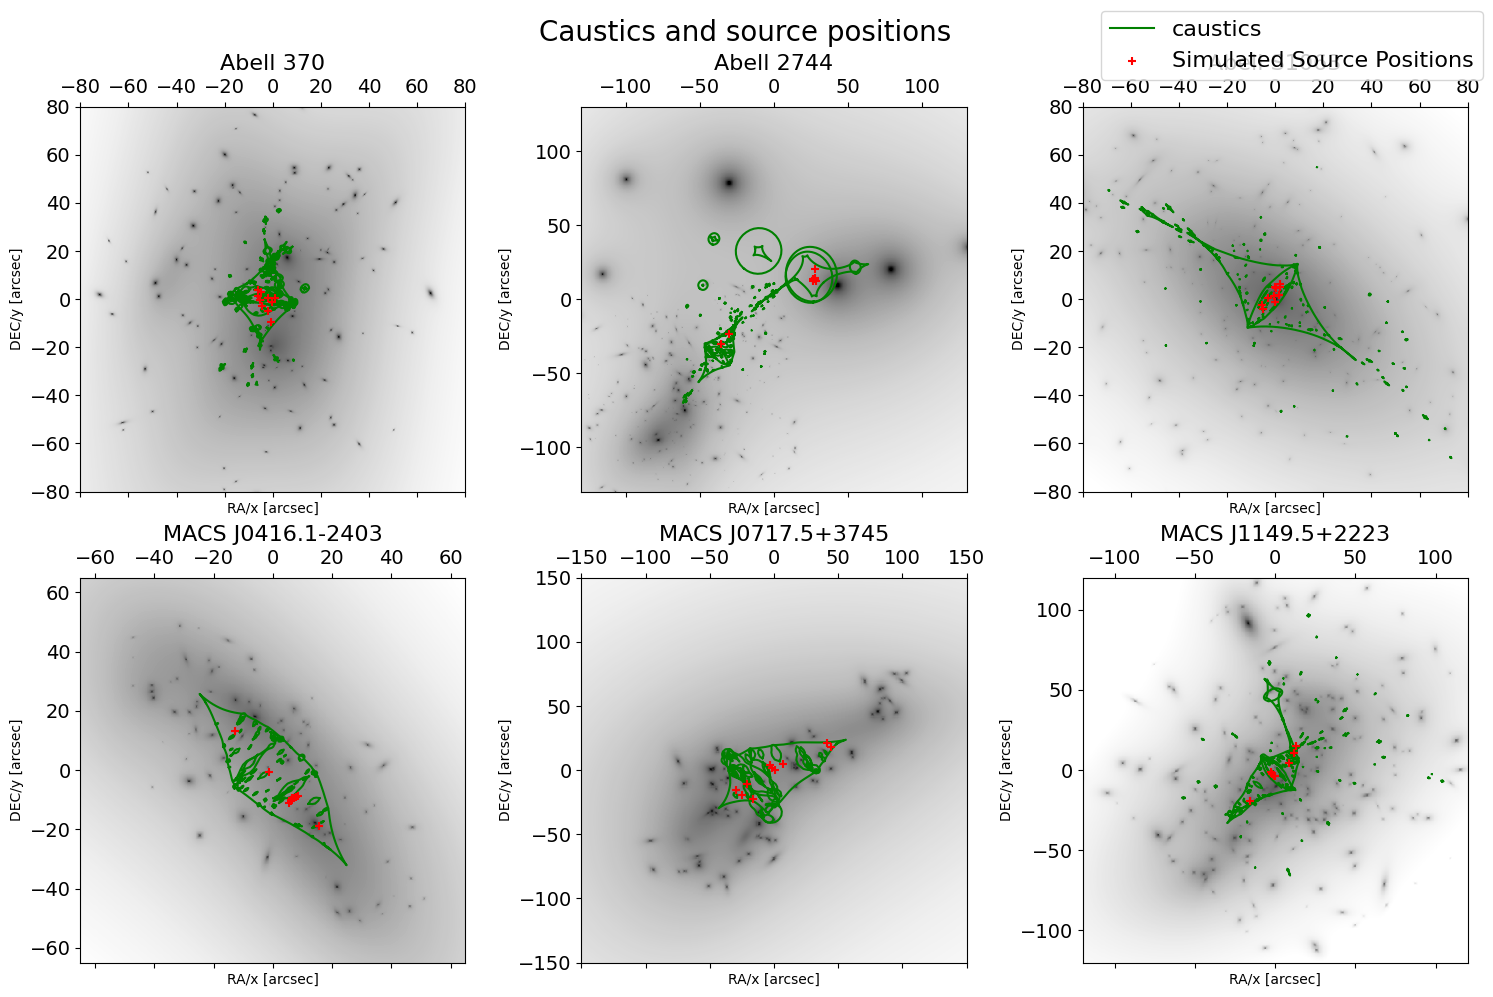

In [6]:
# plot the caustic for the six clusters, not the critical curves

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Caustics and source positions', fontsize=20)

csv_path = '/home/dices/Research/GWlensing_Brian/src_pos_tidy_xyz.csv'
src_pos_df = pd.read_csv(csv_path)

for index in range(6):
    lm = LensModel(lens_model_list=["INTERPOL"], z_lens=z_l_list[index], cosmo=cosmology)

    fx  = np.asarray(datax_list[index])        # α_x
    fy  = np.asarray(datay_list[index])        # α_y
    psi = np.asarray(data_psi_list[index])     # potential

    ny, nx = fx.shape
    pixscale = float(pixscale_list[index])     # arcsec / pixel

    # centered, ASCENDING grids (match lenstronomy's expectation)
    x_grid = (np.arange(nx) - (nx - 1)/2.0) * pixscale
    y_grid = (np.arange(ny) - (ny - 1)/2.0) * pixscale
    if y_grid[0] > y_grid[-1]:
        y_grid = y_grid[::-1]
        fx  = fx [::-1, :]
        fy  = fy [::-1, :]
        psi = psi[::-1, :]

    kwargs = [{
        "grid_interp_x": x_grid,
        "grid_interp_y": y_grid,
        "f_":  psi,
        "f_x": fx,
        "f_y": fy,
    }]

    ax = axs[index//3, index%3]
    numpix = max(nx, ny)
    lens_plot.lens_model_plot(
    ax, lm, kwargs,
    numPix=numpix, deltaPix=pixscale,
    with_caustics=True, with_convergence=True,
    kwargs_caustics={"color_crit": (1, 0, 0, 0)}  # invisible RGBA
    )

    # drop the dummy legend handle that says "critical curves"
    for ln in ax.get_lines():
        if ln.get_label() == "critical curves":
            ln.remove()
    ax.tick_params(labelsize=14)
    ax.set_title(f'{full_cluster_names[scenarios[str(index+1)]]}', fontsize=16)
    # ax.set_xlabel('x [arcsec]', fontsize=16)
    # ax.set_ylabel('y [arcsec]', fontsize=16)

    # --- source positions (CSV is in arcsec on [0,size]x[0,size]) ---
    cluster_indices = src_pos_df[src_pos_df['indices'] == index]
    x_csv = cluster_indices['x'].values  # arcsec in [0, size_x]
    y_csv = cluster_indices['y'].values  # arcsec in [0, size_y]

    # field-of-view from your interpolation grid (arcsec)
    x_min, x_max = float(x_grid[0]), float(x_grid[-1])
    y_min, y_max = float(y_grid[0]), float(y_grid[-1])
    size_x = x_max - x_min
    size_y = y_max - y_min

    # If your CSV y increases downward (image-row style), flip it once:
    csv_y_down = False  # set True if needed
    if csv_y_down:
        y_csv = size_y - y_csv

    # Shift [0, size] --> [x_min, x_max] (and same for y)
    x_arcsec = x_csv + x_min
    y_arcsec = y_csv + y_min

    # (Optional) safety: clip tiny FP drifts to grid range
    eps = 1e-8
    x_arcsec = np.clip(x_arcsec, x_min - eps, x_max + eps)
    y_arcsec = np.clip(y_arcsec, y_min - eps, y_max + eps)

    ax.scatter(x_arcsec, y_arcsec, c='red', marker='+',
               label='Simulated Source Positions', s=30, zorder=10)

# per-panel limits
axs[0,1].set_xlim(-130, 130); axs[0,1].set_ylim(-130, 130)
axs[0,2].set_xlim(-80, 80);   axs[0,2].set_ylim(-80, 80)
axs[1,0].set_xlim(-65, 65);   axs[1,0].set_ylim(-65, 65)
axs[1,1].set_xlim(-150, 150); axs[1,1].set_ylim(-150, 150)
axs[1,2].set_xlim(-120, 120); axs[1,2].set_ylim(-120, 120)

handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=16)
plt.tight_layout()

#fig.colorbar(im, ax=axs.ravel().tolist(), label='|Magnification|', shrink=0.6)
#plt.figtext(0.5, -0.06, 'Figure 2: Plots for stimulated and optimized source positions after localization for each cluster. All the orange and magenta labels of the source positions\nare overlapping each other except one, which indicates that the optimized result is very close to true source positions most of the time.', ha='center', fontsize=14)
plt.savefig('Report images sem2/new/caustic and simulated src v2.png', bbox_inches='tight')

Text(0, 0.5, 'y (arcsec)')

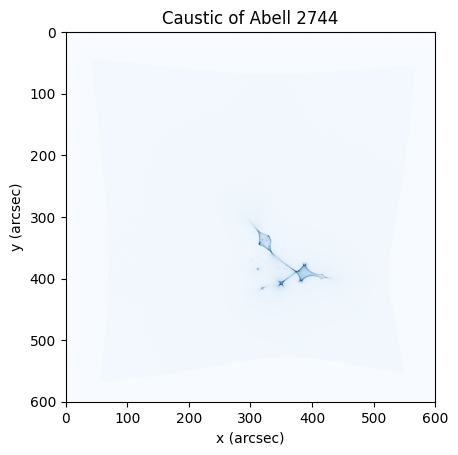

In [34]:
size = len(datax_list[1])
array_test = np.zeros((size, size))
pixscale = pixscale_list[1]
datay = datay_list[1] / pixscale
datax = datax_list[1] / pixscale
for j in range(0, size):
    for k in range(0, size):
        ycoord = j - datay[j, k]
        xcoord = k - datax[j, k]
        ydec = ycoord % 1
        xdec = xcoord % 1
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        array_test[yfloor, xfloor] += 1
plt.imshow(array_test, cmap='Blues', vmax=50, extent=[0, size * pixscale, pixscale * size, 0])
plt.title("Caustic of Abell 2744")

plt.xlabel('x (arcsec)')
plt.ylabel('y (arcsec)')

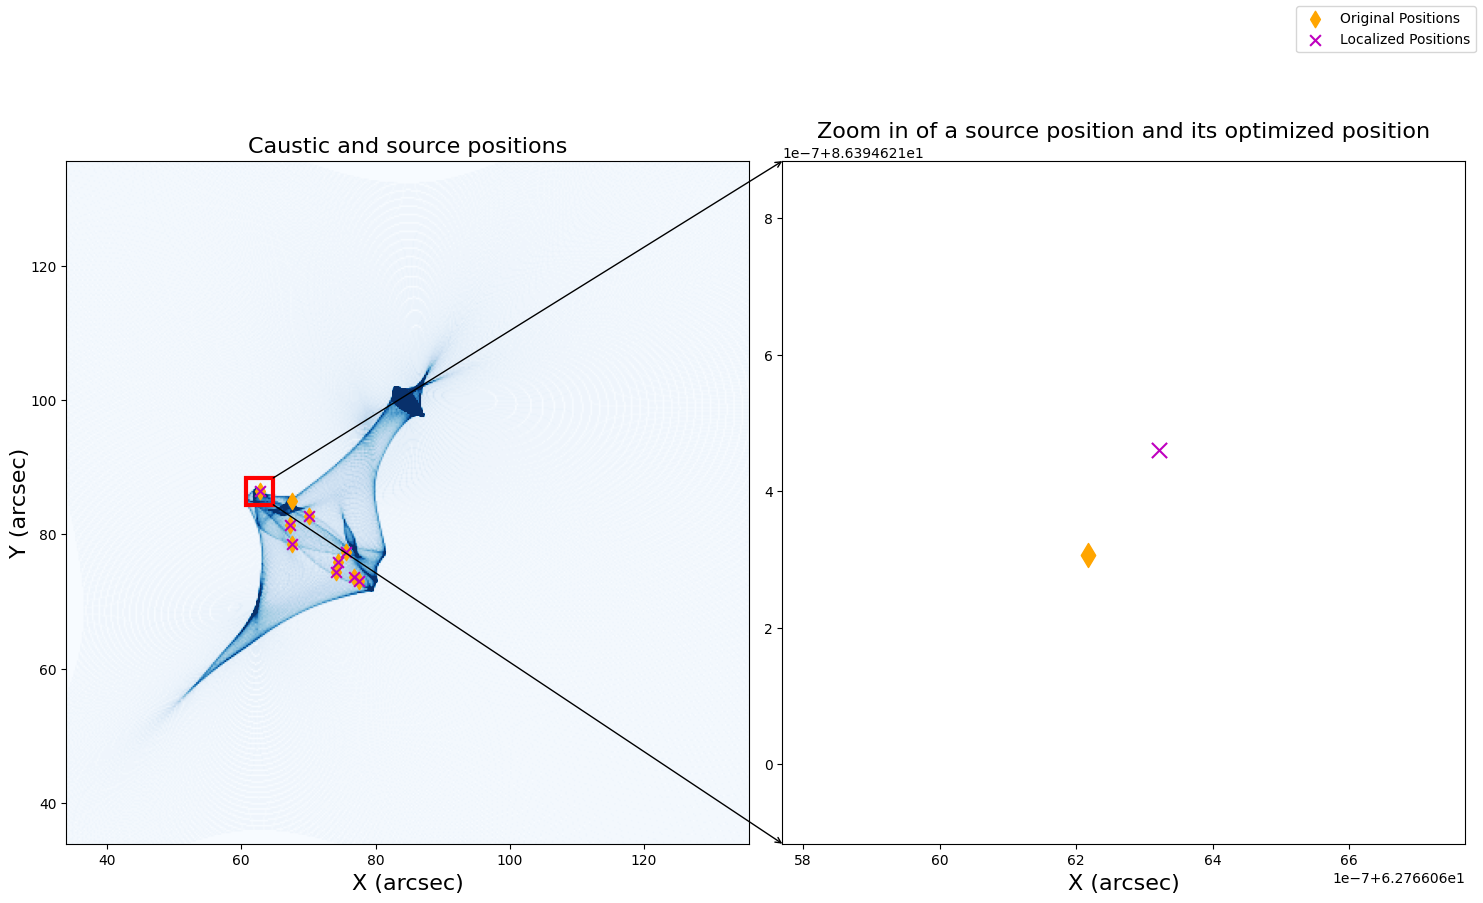

In [ ]:
import matplotlib.patches as patches
# plot one source and its optimized source
fig, axes = plt.subplots(1,2, figsize=(15, 10))
description = ['Abell 370', 'Abell 2744', 'Abell S1063', 'MACS J0416.1-2403', 'MACS J0717.5+3745', 'MACS J1149.5+2223']

# Display the stimulated caustic on the right subplot
size = len(datax_list[1])
array_test = np.zeros((size, size))
pixscale = pixscale_list[1]
datay = datay_list[1] / pixscale
datax = datax_list[1] / pixscale
for j in range(0, size):
    for k in range(0, size):
        ycoord = j - datay[j, k]
        xcoord = k - datax[j, k]
        ydec = ycoord % 1
        xdec = xcoord % 1
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        array_test[yfloor, xfloor] += 1
axes[0].imshow(array_test, cmap='Blues', vmax=50, extent=[0, size * pixscale, pixscale * size, 0])

# Calculate new limits
x_center = size * pixscale / 2
y_center = size * pixscale / 2
x_range = size * pixscale * 0.6
y_range = size * pixscale * 0.6

axes[0].set_xlim(x_center - x_range / 2, x_center + x_range / 2)
axes[0].set_ylim(y_center + y_range / 2, y_center - y_range / 2)

# Invert the y-axis
axes[0].invert_yaxis()

# Load the source positions from the CSV file
src_pos_df = pd.read_csv('src_pos_for_distribution_2nd.csv')

# Extract the (x, y) and (localized_x, localized_y) for the current cluster
cluster_indices = src_pos_df[src_pos_df['indices'] == 1]
guess_indices = cluster_indices['localized_index'].values
x = cluster_indices['x'].values
y = cluster_indices['y'].values

localized_x = cluster_indices['localized_x'].values
localized_y = cluster_indices['localized_y'].values
# Coordinates to remove
x_remove = 71.52470729854495
y_remove = 56.8670826021088

# Find the index where the (x, y) pair matches
remove_index = np.where((localized_x == x_remove) & (localized_y == y_remove))[0]

# Remove the values at that index
localized_x = np.delete(localized_x, remove_index)
localized_y = np.delete(localized_y, remove_index)
# Plot the extracted positions on the current cluster's caustic plot
axes[0].scatter(x, y, c='orange', marker='d', label='Original Positions', s=70)
axes[0].scatter(localized_x, localized_y, c='m', marker='x', label='Localized Positions', s=60)

size = 100
zoom_box_size = 4


# Draw a rectangle around the zoomed region
zoom_rect = patches.Rectangle((62.766066217725225-2,86.39462130682548-2),
                               zoom_box_size, zoom_box_size,
                               linewidth=3, edgecolor='red', facecolor='none', rotation_point="center")
axes[0].add_patch(zoom_rect)

# Add arrows connecting the zoom region to the right plot
for i, pos in enumerate([(62.766066217725225 + zoom_box_size / 2, 86.39462130682548 - zoom_box_size / 2),
                         (62.766066217725225 + zoom_box_size / 2, 86.39462130682548 + zoom_box_size / 2)]):
    con = patches.ConnectionPatch(xyA=pos, xyB=(0, 0) if i == 0 else (0, 1),
                                  coordsA="data", coordsB="axes fraction",
                                  axesA=axes[0], axesB=axes[1],
                                  color="black", arrowstyle="->")
    fig.add_artist(con)

axes[1].scatter(62.766066217725225,86.39462130682548, c='orange', marker='d', s=150)
axes[1].scatter(62.76606632104643,86.39462146020765, c='m', marker='x',  s=120)
x_cen = (62.766066217725225+62.76606632104643)/2
y_cen = (86.39462130682548+86.39462146020765)/2
axes[1].set_xlim(x_cen - 5e-7, x_cen + 5e-7)
axes[1].set_ylim(y_cen - 5e-7, y_cen + 5e-7)
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_title('Zoom in of a source position and its optimized position', fontsize=16)
fig.legend()
fig.axes[0].set_title('Caustic and source positions', fontsize=16)
fig.supylabel('Y (arcsec)', fontsize=16)
axes[0].set_xlabel('X (arcsec)', fontsize=16)
axes[1].set_xlabel('X (arcsec)', fontsize=16)


# Adjust spacing
plt.tight_layout()
plt.show()

# save as pdf file
fig.savefig('Report images/zoom in src and optimized.pdf')

In [ ]:
# plot one source and its optimized source
fig, axes = plt.subplots(1,2, figsize=(15, 10))
description = ['Abell 370', 'Abell 2744', 'Abell S1063', 'MACS J0416.1-2403', 'MACS J0717.5+3745', 'MACS J1149.5+2223']

# Display the stimulated caustic on the right subplot
size = len(datax_list[5])
array_test = np.zeros((size, size))
pixscale = pixscale_list[0]
datay = datay_list[0] / pixscale
datax = datax_list[0] / pixscale
for j in range(0, size):
    for k in range(0, size):
        ycoord = j - datay[j, k]
        xcoord = k - datax[j, k]
        ydec = ycoord % 1
        xdec = xcoord % 1
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        array_test[yfloor, xfloor] += 1
axes[0].imshow(array_test, cmap='Blues', vmax=50, extent=[0, size * pixscale, pixscale * size, 0])
# Calculate new limits
x_center = size * pixscale / 2
y_center = size * pixscale / 2
x_range = size * pixscale * 0.6
y_range = size * pixscale * 0.6

axes[0].set_xlim(x_center - x_range / 2, x_center + x_range / 2)
axes[0].set_ylim(y_center + y_range / 2, y_center - y_range / 2)



# Invert the y-axis
axes[0].invert_yaxis()
# Load the source positions from the CSV file
src_pos_df = pd.read_csv('simulated_sources.csv')

# Extract the (x, y) and (localized_x, localized_y) for the current cluster
cluster_indices = src_pos_df[src_pos_df['indices'] == 0]
x = cluster_indices['x'].values
y = cluster_indices['y'].values

localized_x = cluster_indices['localized_x'].values
localized_y = cluster_indices['localized_y'].values
chi_sq = cluster_indices['localized_chi_sq'].values
axes[0].scatter(x, y, c='orange', marker='d', label='Original Positions', s=50)
#axes[0].scatter(localized_x, localized_y, c='m', marker='x', label='Localized Positions', s=50)
axes[0].set_title('Simulated source position and optimized source position')
axes[0].legend()
axes[0].set_xlabel('X (arcsec)')
axes[0].set_ylabel('Y (arcsec)')

axes[1].hist(chi_sq, bins = 10,rwidth=0.7)
axes[1].set_title('Chi squared distribution of the optimized source positions')
axes[1].set_xlabel('Chi squared')
axes[1].set_ylabel('Frequency')

plt.show()
fig.savefig('Report images/known_cluster.pdf')

Text(0, 0.5, 'Frequency')

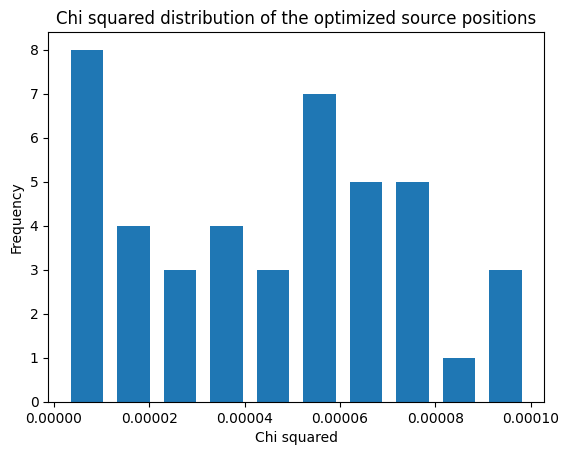

In [ ]:
plt.hist(chi_sq, bins = 10,rwidth=0.7)
plt.title('Chi squared distribution of the optimized source positions')
plt.xlabel('Chi squared')
plt.ylabel('Frequency')

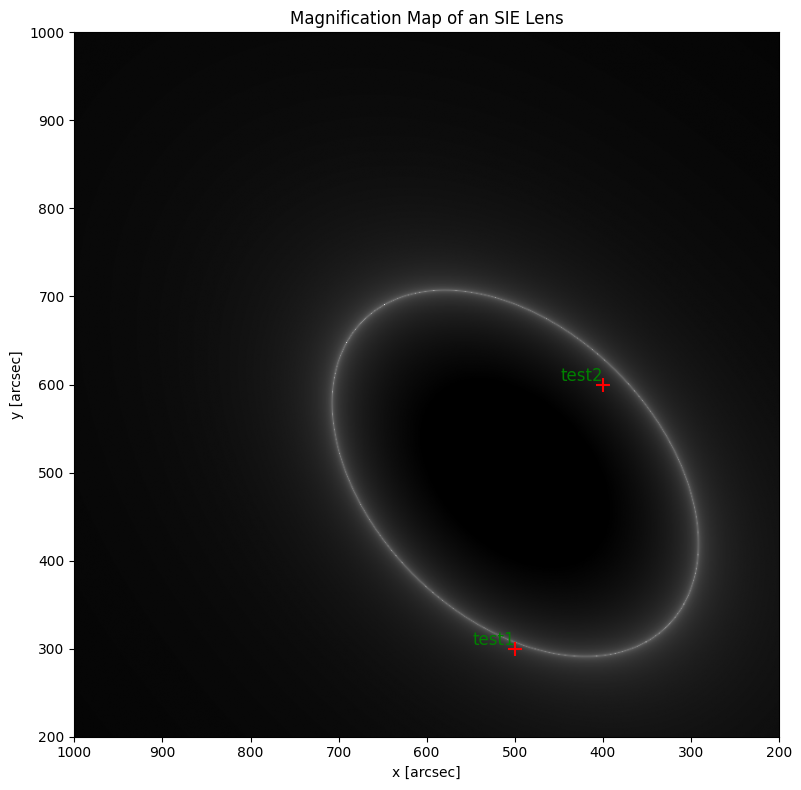

In [7]:
# use sie lens with similar values to verify the correctness of the model

#checking the vaildity of the source plane map

import matplotlib.pyplot as plt
# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

kwargs_sie = {
    'theta_E': 1.0,  # Einstein radius
    'e1': 0,       # Ellipticity component 1
    'e2': 0.2,       # Ellipticity component 2
    'center_x': 0.0, # x-coordinate of the center
    'center_y': 0.0  # y-coordinate of the center
}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
grid_num = 1000
delta_pix = 0.005
x = np.linspace(-grid_num/2 * delta_pix, grid_num/2 * delta_pix, grid_num)
y = np.linspace(-grid_num/2 * delta_pix, grid_num/2 * delta_pix, grid_num)
xx, yy = np.meshgrid(x, y)

# 4. Calculate the magnification on the grid
magnification_map = lensModel.magnification(xx, yy, kwargs=kwargs_lens)

# 5. Plot the magnification map
plt.figure(figsize=(8, 8))
plt.imshow(
    np.log10(np.abs(magnification_map)),
    origin='lower',
    # extent=[x[0], x[-1], y[0], y[-1]],
    cmap='grey',
    vmin=0
    
)
x = [500,400]
y = [300,600]
txt =['test1','test2']
plt.scatter(x,y, c='red', marker='+', s=100)
for i, txt in enumerate(txt):
    plt.annotate(txt, (x[i], y[i]), color='green', fontsize=12, ha='right', va='bottom')
# plt.colorbar(label='log10(|Magnification|)')
plt.title('Magnification Map of an SIE Lens')

plt.xlabel('x [arcsec]')
plt.ylabel('y [arcsec]')
plt.grid(False)
#plt.axis(False)
plt.tight_layout()
plt.xlim(1000,200)
plt.ylim(200,1000)
# invert x axis
#plt.gca().invert_xaxis()
plt.show()
      


/home/dices/.venv/lib/python3.12/site-packages/lenstronomy/LensModel/lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(


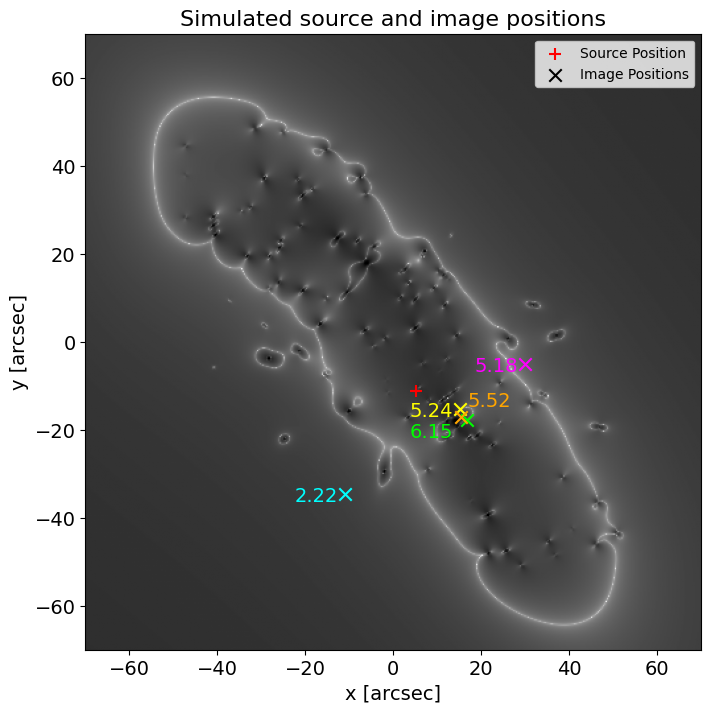

In [7]:
# magnification map for the real cluster models
from matplotlib.colors import LogNorm
index = 3
lm = LensModel(lens_model_list=["INTERPOL"],
                           z_lens=z_l_list[index], cosmo=cosmology)
size = len(datax_list[index])
pixscale = pixscale_list[index]
x_grid = np.linspace(-size/2*pixscale, size/2*pixscale, size)
xx, yy = np.meshgrid(x_grid, x_grid)
kwargs = [{
            "grid_interp_x": x_grid,
            "grid_interp_y": x_grid,
            "f_": data_psi_list[index],
            "f_x": datax_list[index],
            "f_y": datay_list[index],
        }]

magnification_map = lm.magnification(xx, yy, kwargs=kwargs)
plt.figure(figsize=(8, 8))
plt.imshow(
    np.abs(magnification_map),
    origin='lower',
    cmap='gray',
    norm=LogNorm(vmin=1e-1, vmax=1e5),
    extent=[x_grid[0], x_grid[-1], x_grid[0], x_grid[-1]],
    
)
# import the source positions
src_pos_df = pd.read_csv('/home/dices/Research/GWlensing_Brian/src_pos_tidy_xyz.csv')
x = src_pos_df['x'][34]-size/2*pixscale
y = src_pos_df['y'][34]-size/2*pixscale
plt.scatter(x, y, c='red', s=80, marker='+', label='Source Position')

x_img = np.array([109.02030167, 149.93462669, 135.15484138, 136.74699818,
    135.4035407 ])-size/2*pixscale
y_img = np.array([ 85.28355265, 114.92104076, 104.67796852, 102.12769722,
    102.83284496])-size/2*pixscale
mu = [ 2.22215245,  5.1769496 , 5.23512948, 6.14662424,  5.51546039]


colors = ['cyan', 'magenta', 'yellow', 'lime', 'orange']

# Plot each image position with a different color and annotate
for i in range(len(x_img)):
    label = 'Image Positions' if i == 0 else None
    plt.scatter(x_img[i], y_img[i], color=colors[i], s=80, marker='x', label=label)
    
    # Adjust text position to avoid overlap
    if i == 3:
        ha, va = 'right', 'bottom'
        xytext = (-10, -15)
    elif i == 4:
        ha, va = 'left', 'bottom'
        xytext = (5, 5)
    else:
        ha, va = 'right', 'bottom'
        xytext = (-5, -8)
        
    plt.annotate(f'{mu[i]:.2f}', (x_img[i], y_img[i]), textcoords="offset points", xytext=xytext, color=colors[i], fontsize=14, ha=ha, va=va)

plt.xlabel('x [arcsec]', fontsize=14)
plt.ylabel('y [arcsec]', fontsize=14)
plt.tick_params(labelsize=14)
plt.xlim(-70, 70)
plt.ylim(-70, 70)
handles, labels =  plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=labels)
leg = plt.gca().get_legend()
leg.legend_handles[1].set_facecolor('black')
leg.legend_handles[1].set_edgecolor('black')

#plt.colorbar(label='|Magnification|')
plt.title('Simulated source and image positions', fontsize=16)
plt.savefig('Report images sem2/new/src and img.pdf', bbox_inches='tight')

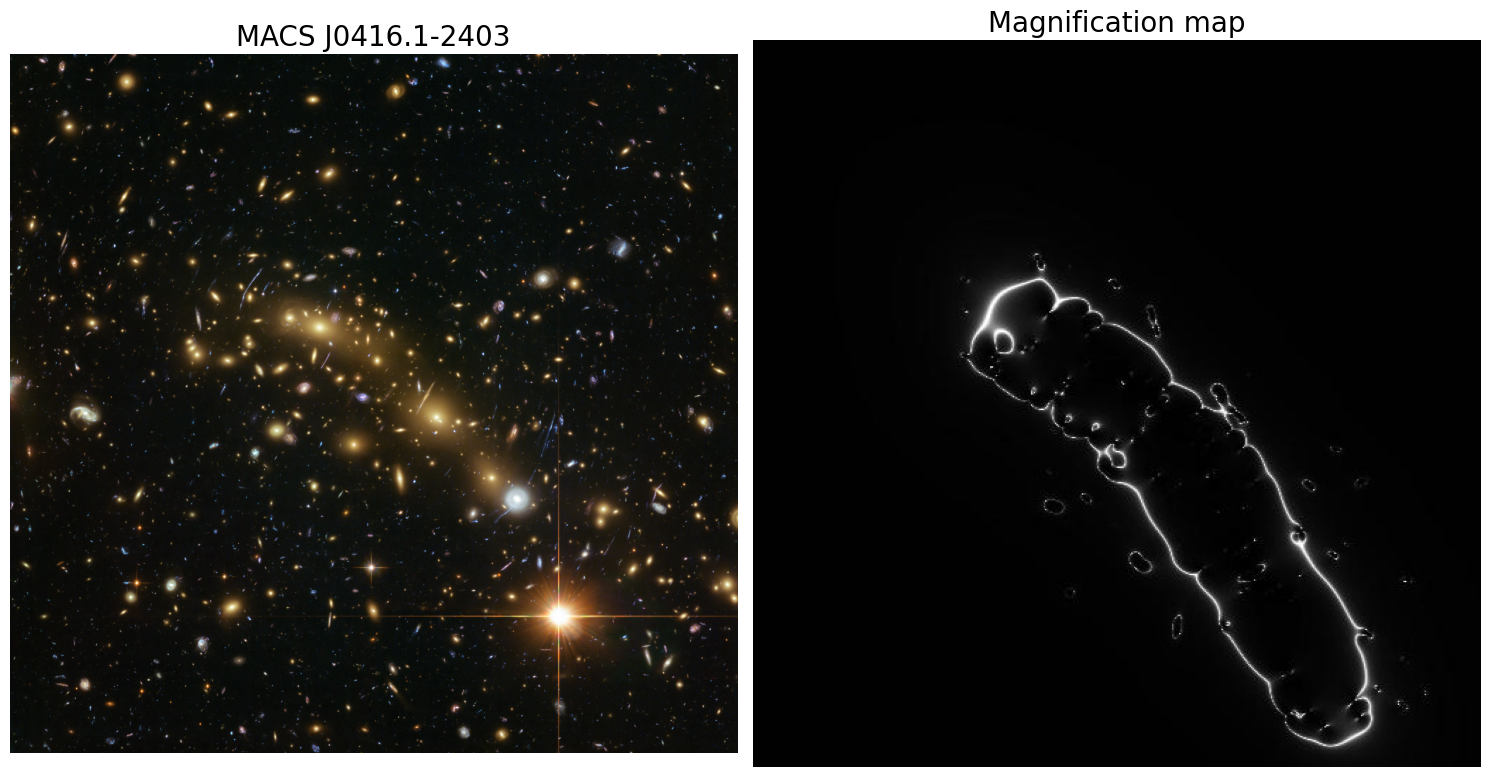

In [28]:
from PIL import Image

# List of image filenames
image_filenames = ['Report images sem2/new/illustration 370.jpg','Report images sem2/new/illustration 2744.JPG','Report images sem2/new/illustration s1063.tif', 
                   'Report images sem2/new/illustration j0416.JPG', 'Report images sem2/new/illustration j0717.JPG', 'Report images sem2/new/illustration j1149.JPG']

# Number of rows and columns
rows = 1
cols = 2

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
description = ['Abell 370', 'Abell 2744', 'Abell S1063', 'MACS J0416.1-2403', 'MACS J0717.5+3745', 'MACS J1149.5+2223']

# only open the image of Abell 2744 at left and stimulated caustic at right
# Open the image of Abell 2744
image1 = Image.open(image_filenames[3])
image2 = Image.open('Report images sem2/new/macs0416_cats_v4_z04-magnif.jpg')
# Display the image on the left subplot
axes[0].imshow(image1)
axes[0].set_title(description[3], fontsize=20)
axes[0].axis('off')

axes[1].imshow(image2)
axes[1].set_title('Magnification map', fontsize=20)
axes[1].axis('off')

# Display the stimulated caustic on the right subplot
# axes[2].imshow(
#     np.log10(np.abs(magnification_map)),
#     origin='lower',
#     # extent=[x[0], x[-1], y[0], y[-1]],
#     cmap='grey',
#     vmin=0
    
# )
# # plt.colorbar(label='log10(|Magnification|)')
# axes[2].set_title('Magnification Map of an SIE Lens', fontsize=20)

# axes[2].set_xlabel('x [arcsec]')
# axes[2].set_ylabel('y [arcsec]')
# axes[2].grid(False)
# axes[2].axis('off')
# axes[2].set_xlim(1000,200)
# axes[2].set_ylim(200,1000)

# Adjust spacing
plt.tight_layout()
plt.show()
#fig.savefig('Report images/illustration_v2.pdf')

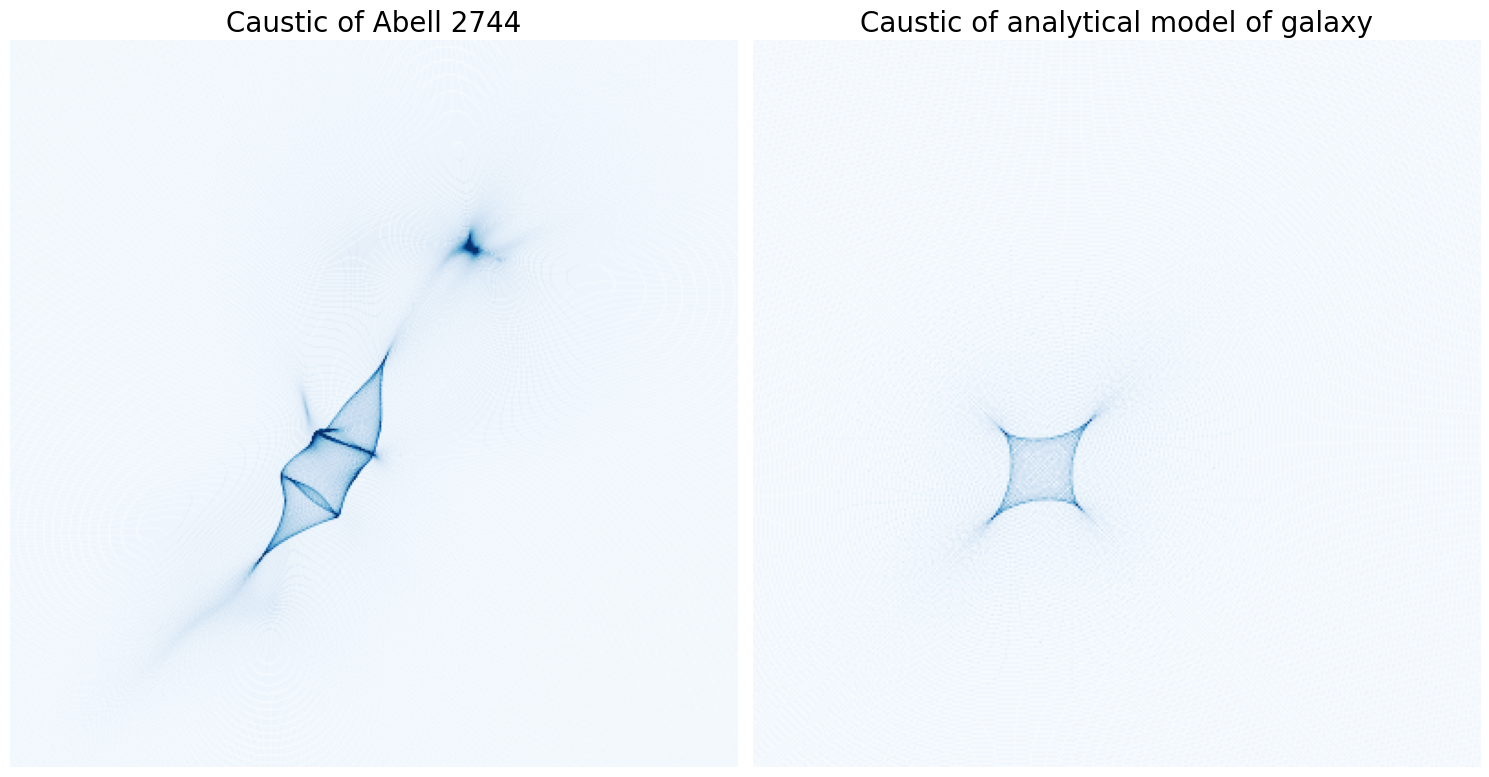

In [25]:
# illustrate the casutic
array_test1 = np.zeros([678,678])

for i in range(0, 678):
    for j in range(0, 678):
        ycoord = i-alpha_y_2d[i,j] # src coord
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        xceil = ceil(xcoord)
        yceil = ceil(ycoord)
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        if i%2==0 and j%2==0:
            array_test1[yfloor,xfloor] += 1 
      

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
description = ['Abell 370', 'Abell 2744', 'Abell S1063', 'MACS J0416.1-2403', 'MACS J0717.5+3745', 'MACS J1149.5+2223']

# only open the image of Abell 2744 at left and stimulated caustic at right
# Open the image of Abell 2744
image = Image.open(image_filenames[1])

# Display the image on the left subplot
axes[0].imshow(array_test, cmap='Blues', vmax=50, extent=[0, size * pixscale, pixscale * size, 0])
axes[0].set_xlim(26, 125.5)
axes[0].set_ylim(134.5, 35)
axes[0].invert_yaxis()
axes[0].set_title('Caustic of Abell 2744', fontsize=20)
axes[0].axis('off')

# Display the stimulated caustic on the right subplot
axes[1].imshow(array_test1, cmap='Blues', extent=[0, size * pixscale, pixscale * size, 0])
axes[1].set_xlim(36, 115.5)
axes[1].set_ylim(124.5, 45)
axes[1].invert_yaxis()
axes[1].set_title('Caustic of analytical model of galaxy', fontsize=20)
axes[1].axis('off')

plt.tight_layout()
plt.savefig('Report images sem2/new/caustic of sie.pdf')